# MLP - MM21B051 - Preethi
The pdf version of this notebook has all outputs and graphs, kindly refer to it
We begin with loading the dataset, I have downloaded it locally
We unpickle the dataset as mentioned in the official website and convert into a torch tensor, so that we can calculate the gradients and back-propagate in the later stages.

In [2]:
import pickle
import numpy as np
import torch

# Function to unpickle a CIFAR-10 batch file
def unpickle(file):
    with open(file, 'rb') as fo:
        data_dict = pickle.load(fo, encoding='bytes')
    return data_dict

# Load all 5 training batches
data_path = 'C:/Users/Preethi/Downloads/EE5178-Assgn1/cifar-10-python/cifar-10-batches-py/'
train_data, train_labels = [], []

for i in range(1, 6):  # Load batches 1 to 5
    batch = unpickle(f"{data_path}data_batch_{i}")
    train_data.append(batch[b'data'])  # Image data (shape: (10000, 3072))
    train_labels.extend(batch[b'labels'])  # Labels

# Convert to NumPy arrays
train_data = np.vstack(train_data).astype(np.float32)  # Shape: (50000, 3072)
train_labels = np.array(train_labels)  # Shape: (50000,)

# Load test batch
test_batch = unpickle(f"{data_path}test_batch")
test_data = np.array(test_batch[b'data'], dtype=np.float32)  # Shape: (10000, 3072)
test_labels = np.array(test_batch[b'labels'])  # Shape: (10000,)

# Convert NumPy arrays to PyTorch tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print dataset shapes
print(f"Train data shape: {train_data.shape}, Train labels shape: {train_labels.shape}")
print(f"Test data shape: {test_data.shape}, Test labels shape: {test_labels.shape}")
print(f"Data stored on: {device}")


Train data shape: (50000, 3072), Train labels shape: (50000,)
Test data shape: (10000, 3072), Test labels shape: (10000,)
Data stored on: cpu


We convert the data into torch tensors and define the model with three hidden layers: h1 (500 units), h2 (250 units), and h3 (100 units), 10 units at the output layer, one for each class. The input layer is the flattened image vector. We use ReLu as the actuvation function in between each layer. The loss used is cross-entropy loss, we compute the gradients wrt to this loss and optimize the weights and biases, through back-propagation.

Epoch [1/30] - Train Loss: 2.3001, Val Loss: 2.2940, Accuracy: 14.72%
Epoch [2/30] - Train Loss: 2.2638, Val Loss: 2.2256, Accuracy: 22.60%
Epoch [3/30] - Train Loss: 2.1953, Val Loss: 2.1705, Accuracy: 28.21%
Epoch [4/30] - Train Loss: 2.1658, Val Loss: 2.1527, Accuracy: 30.25%
Epoch [5/30] - Train Loss: 2.1483, Val Loss: 2.1403, Accuracy: 31.31%
Epoch [6/30] - Train Loss: 2.1299, Val Loss: 2.1257, Accuracy: 32.69%
Epoch [7/30] - Train Loss: 2.1127, Val Loss: 2.1172, Accuracy: 33.59%
Epoch [8/30] - Train Loss: 2.1018, Val Loss: 2.0956, Accuracy: 35.96%
Epoch [9/30] - Train Loss: 2.0926, Val Loss: 2.0894, Accuracy: 36.54%
Epoch [10/30] - Train Loss: 2.0822, Val Loss: 2.0760, Accuracy: 37.90%
Epoch [11/30] - Train Loss: 2.0737, Val Loss: 2.0713, Accuracy: 38.52%
Epoch [12/30] - Train Loss: 2.0681, Val Loss: 2.0647, Accuracy: 39.15%
Epoch [13/30] - Train Loss: 2.0587, Val Loss: 2.0601, Accuracy: 39.77%
Epoch [14/30] - Train Loss: 2.0515, Val Loss: 2.0439, Accuracy: 41.19%
Epoch [15/30] -

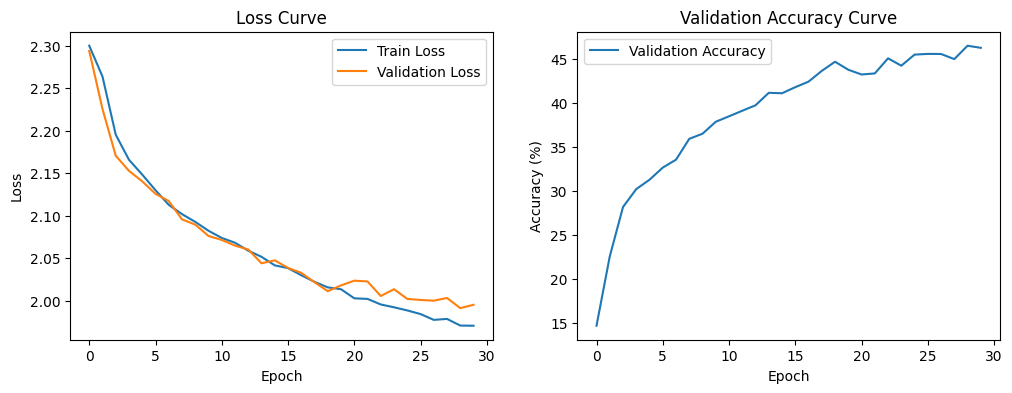

In [3]:
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
from torchvision import transforms

# Normalize data to [0,1]
train_data /= 255.0
test_data /= 255.0

# Convert to PyTorch tensors
train_data = torch.tensor(train_data)
train_labels = torch.tensor(train_labels)
test_data = torch.tensor(test_data)
test_labels = torch.tensor(test_labels)

# Create PyTorch DataLoader
batch_size = 128
train_dataset = data.TensorDataset(train_data, train_labels)
test_dataset = data.TensorDataset(test_data, test_labels)
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define MLP Model
class MLP(nn.Module):
    def __init__(self, input_size=3072, hidden_sizes=[500, 250, 100], output_size=10):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return self.softmax(x)

# Initialize model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Training loop
num_epochs = 30
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Compute validation loss and accuracy
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_loss / len(test_loader))
    val_accuracies.append(100 * correct / total)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_losses[-1]:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}, Accuracy: {val_accuracies[-1]:.2f}%")

# Plot training & validation loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Validation Accuracy Curve")

plt.show()


As we can see from the graphs, the validation and training losses progressively deacrease with each epoch, and the accuracy is 46% at the end of 30 epochs, and val loss is 1.99.

We will now test the model's performance on the test data set.

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


test_batch = unpickle('C:/Users/Preethi/Downloads/EE5178-Assgn1/cifar-10-python/cifar-10-batches-py/test_batch')
test_data = test_batch[b'data'].reshape(-1, 3, 32, 32).astype(np.float32) / 255.0
test_labels = np.array(test_batch[b'labels'])

# Convert to PyTorch tensors
test_data = torch.tensor(test_data).float()
test_labels = torch.tensor(test_labels).long()

# Create DataLoader
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_data, test_labels), batch_size=64, shuffle=False)

# ----------- Evaluate the Model (Average Test Accuracy) -----------
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images.view(images.size(0), -1))  # Flatten the input
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_accuracy = 100 * correct / total
print(f"\nAverage Test Accuracy: {test_accuracy:.2f}%")



Average Test Accuracy: 46.30%


Next, we randomly visualise the prediction of the model on a few images

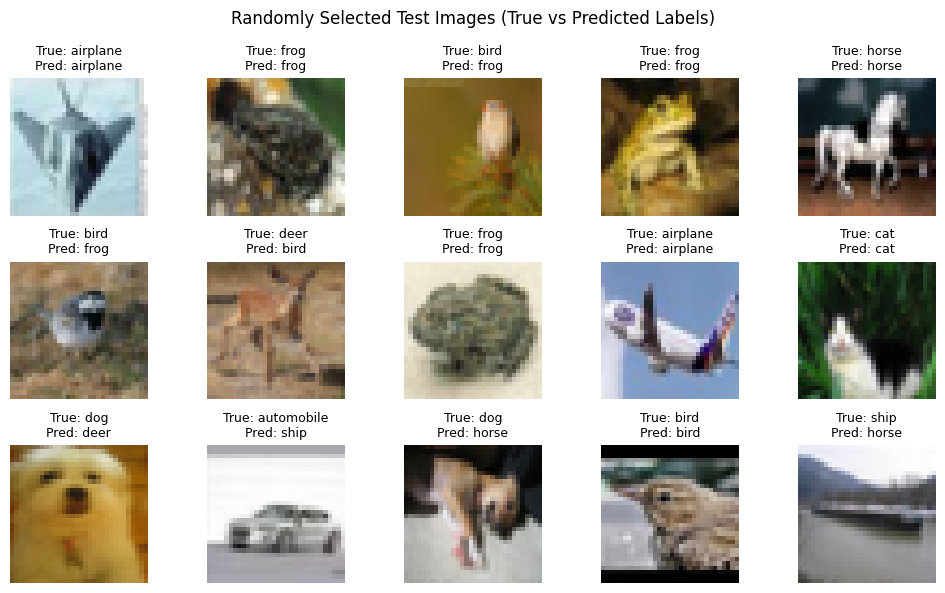

In [7]:
# ----------- Display Random Test Images with Predictions -----------
import random

class_names = unpickle('C:/Users/Preethi/Downloads/EE5178-Assgn1/cifar-10-python/cifar-10-batches-py/batches.meta')[b'label_names']
class_names = [name.decode('utf-8') for name in class_names]

fig, axes = plt.subplots(3, 5, figsize=(10, 6))
fig.suptitle("Randomly Selected Test Images (True vs Predicted Labels)", fontsize=12)

model.eval()
for i in range(3):
    for j in range(5):
        idx = random.randint(0, len(test_data) - 1)
        image = test_data[idx].numpy().transpose(1, 2, 0)
        true_label = class_names[test_labels[idx].item()]
        
        with torch.no_grad():
            output = model(test_data[idx].view(1, -1).to(device))  # Flatten before passing to the model
            pred_label = class_names[output.argmax().item()]
        
        axes[i, j].imshow(image)
        axes[i, j].set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=9)
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()


Confusion matrix for the true vs predicted labels of the model on the test dataset, we see that truck, horse, airplane and automobile have the best predictions, while bird, dog and deer are lesser accurate.

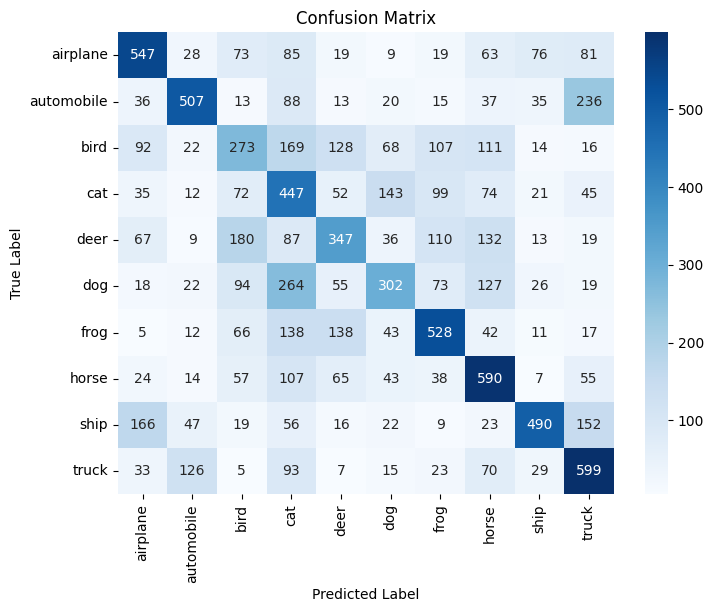

In [8]:
# ----------- Compute and Display Confusion Matrix -----------
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images.view(images.size(0), -1))  # Flatten the input
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

We next train the model with batch normalisation layers added. Batch normalisation, normalises the outputs of each layer before they are passed onto the subsequent layer. WE further plot the training and validation losses, accuracy for the batch normalised model.

Epoch 1/20 - Train Loss: 1.6034, Val Loss: 1.4885, Train Acc: 42.73%, Val Acc: 46.83%
Epoch 2/20 - Train Loss: 1.3632, Val Loss: 1.4481, Train Acc: 51.42%, Val Acc: 47.61%
Epoch 3/20 - Train Loss: 1.2526, Val Loss: 1.4225, Train Acc: 55.47%, Val Acc: 49.44%
Epoch 4/20 - Train Loss: 1.1657, Val Loss: 1.4664, Train Acc: 58.34%, Val Acc: 48.36%
Epoch 5/20 - Train Loss: 1.0892, Val Loss: 1.3679, Train Acc: 61.17%, Val Acc: 51.34%
Epoch 6/20 - Train Loss: 1.0211, Val Loss: 1.3553, Train Acc: 63.75%, Val Acc: 53.03%
Epoch 7/20 - Train Loss: 0.9560, Val Loss: 1.4133, Train Acc: 66.05%, Val Acc: 51.47%
Epoch 8/20 - Train Loss: 0.8944, Val Loss: 1.7035, Train Acc: 68.34%, Val Acc: 46.35%
Epoch 9/20 - Train Loss: 0.8355, Val Loss: 1.4213, Train Acc: 70.35%, Val Acc: 52.12%
Epoch 10/20 - Train Loss: 0.7804, Val Loss: 1.5562, Train Acc: 72.15%, Val Acc: 50.25%
Epoch 11/20 - Train Loss: 0.7319, Val Loss: 1.5561, Train Acc: 74.16%, Val Acc: 51.12%
Epoch 12/20 - Train Loss: 0.6725, Val Loss: 1.6603, 

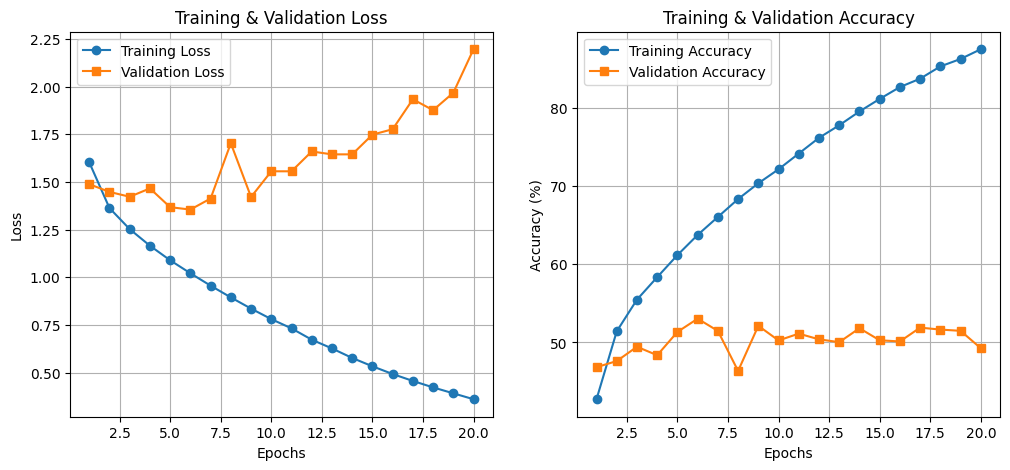

In [ ]:
# Define MLP Model with Batch Normalization
class MLP_CIFAR10_bnorm(nn.Module):
    def __init__(self):
        super(MLP_CIFAR10_bnorm, self).__init__()
        self.fc1 = nn.Linear(3072, 500)
        self.bn1 = nn.BatchNorm1d(500)  # Batch Normalization
        self.fc2 = nn.Linear(500, 250)
        self.bn2 = nn.BatchNorm1d(250)  # Batch Normalization
        self.fc3 = nn.Linear(250, 100)
        self.bn3 = nn.BatchNorm1d(100)  # Batch Normalization
        self.fc4 = nn.Linear(100, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input (32x32x3 → 3072)
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)  # No activation for final logits
        return x  # Softmax applied in loss function

# 3. Train the model
model = MLP_CIFAR10_bnorm().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

num_epochs = 20
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation Loop
    model.eval()
    val_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(test_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

# 4. Plot Loss and Accuracy
epochs = np.arange(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Training Loss", marker="o")
plt.plot(epochs, val_losses, label="Validation Loss", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Training Accuracy", marker="o")
plt.plot(epochs, val_accuracies, label="Validation Accuracy", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid()

plt.show()


Batch normalization doesn't seem to be useful in this case as it seems to be leading to overfitting. The training losses are progressively decreasing, however the validation loss increases and the same can be seen with accuracy too; training accuracy increases drastically, while not much improvement is seen on the validation set.